<a href="https://colab.research.google.com/github/hiyori99/Colaboratory/blob/main/Decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install econml

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from econml.metalearners import XLearner
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
filepath = "https://raw.githubusercontent.com/iwanami-datascience/vol3/master/kato%26hoshino/q_data_x.csv"
df = pd.read_csv(filepath)

#データをダウンロードして学習データとテストデータに分ける
X = df[['area_kanto', 'area_tokai', 'area_keihanshin', 'age', 'sex', 'marry_dummy', 
        'job_dummy1', 'job_dummy2', 'job_dummy3', 'job_dummy4', 'job_dummy5', 
        'job_dummy6', 'job_dummy7', 'inc', 'pmoney', 'fam_str_dummy1', 'fam_str_dummy2', 
        'fam_str_dummy3', 'fam_str_dummy4', 'child_dummy', 'TVwatch_day']]
Y = df['gamesecond']
T = df['cm_dummy']

X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X, Y, T, test_size=0.2, shuffle=True, random_state=42, stratify=T)

In [9]:
Y.describe()

count     10000.000000
mean       2846.783400
std       17973.608991
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      364814.000000
Name: gamesecond, dtype: float64

In [10]:
T.value_counts()

0    5856
1    4144
Name: cm_dummy, dtype: int64

あるCMを見たかどうかが変数T、効果を測りたいアプリの利用時間をYに入れている。

データ数は10,000件で、利用時間の大半は0秒である。
CMを見たかどうかは見てない人が少し多いことがわかる。

Xがユーザーの属性になるわけですが、書籍と照らし合わせてみると

- 地域(area_xxx)
- 年齢(age)
- 性別(sex)
- 年収(inc)
- 1日あたりのテレビ視聴秒数(TVwatch_day)

などがある。

In [12]:
#ユーザー毎の効果を推定する

# Instantiate X learner
n = len(X_test)
models = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
propensity_model = RandomForestClassifier(n_estimators=100, max_depth=6, 
                                                  min_samples_leaf=int(n/100))
X_learner = XLearner(models=models, propensity_model=propensity_model)
# Train X_learner
X_learner.fit(Y_train, T_train, X=X_train)
# Estimate treatment effects on test data
X_te = X_learner.effect(X_test)

print("ATE of X-learner: ", round(np.mean(X_te), 2))

ATE of X-learner:  901.4


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


学習データでモデルを学習し、テストデータのユーザー毎の推定値を算出している。

平均の効果ではアプリの利用時間が931秒伸びたと推定しており、書籍と同様にプラスの効果がありそうだと判断できる。

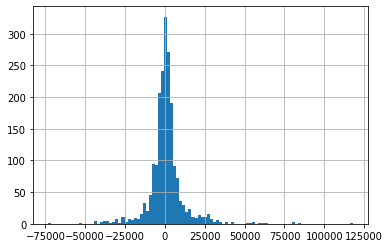

In [13]:
#ユーザー毎の効果をヒストグラムで見る
pd.Series(X_te).hist(bins=100)

縦軸がユーザー数で横軸が効果の秒数である。

効果がマイナスの人のほうが多いようにも見えるが、平均するとプラスのようである。

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.


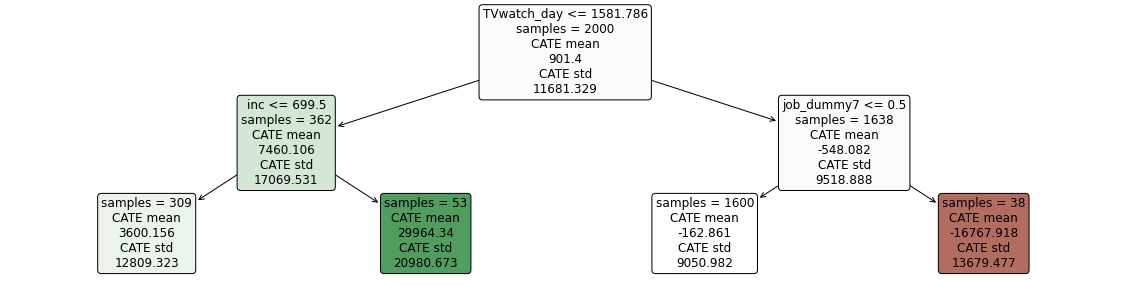

In [14]:
from econml.cate_interpreter import SingleTreeCateInterpreter
intrp = SingleTreeCateInterpreter(max_depth=2, min_samples_leaf=10)
# We interpret the CATE model's behavior based on the features used for heterogeneity
intrp.interpret(X_learner, X_test)
# Plot the tree
plt.figure(figsize=(20, 5))
intrp.plot(feature_names=X_test.columns, fontsize=12)
plt.show()

各ノードの

- 1行目が振り分け条件
- 2行目がユーザー数
- 3, 4行目が効果の平均
- 5, 6行目が効果の標準偏差

になっている。
色については、プラス効果が大きいものが緑、マイナス効果が大きいものが赤くなっている。

2,000件のテストデータのうち、1日のテレビ視聴秒数が短く(TVwatch_dayが1581秒以下)、年収が高い(incが699万円以上)の人が効果が最も大きいと推定している。
また、視聴秒数が長く(TVwatch_dayが1581秒以上)、ある特定の職種(job_dummy7が1)の人が効果が最も小さいと推定している。